In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset


## 1. ETL

In [3]:
from src import spectrumloader as spl

In [5]:
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset

PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'
standard,data_all = spl.read_file('dataset/')

In [6]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [7]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [8]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization

In [9]:
X_train_VR = spl.fluoresence_removal(X_trainall)

In [10]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

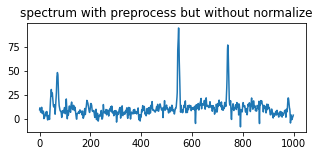

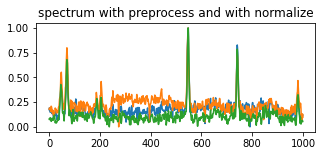

In [11]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train0_std[0])
plt.plot(X_train0_std[7])
plt.plot(X_train0_std[-1])

plt.show()

## 5. apply data to pytorch

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [43]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))

train_set0, val_set0 = torch.utils.data.random_split(ds_earloop, [10, 6])
train_set1, val_set1 = torch.utils.data.random_split(ds_inarm, [10, 6])
train_set2, val_set2 = torch.utils.data.random_split(ds_thumbnail, [10, 6])
train_set3, val_set3 = torch.utils.data.random_split(ds_vain, [10, 6])

In [44]:
batch_size = 10
valbatch_size = 6


train_loader0 = torch.utils.data.DataLoader(dataset=train_set0,batch_size=batch_size,shuffle=True)
val_loader0 = torch.utils.data.DataLoader(dataset=val_set0, batch_size=valbatch_size, shuffle=True)

train_loader1 = torch.utils.data.DataLoader(dataset=train_set1,batch_size=batch_size,shuffle=True)
val_loader1 = torch.utils.data.DataLoader(dataset=val_set1, batch_size=valbatch_size, shuffle=True)

train_loader2 = torch.utils.data.DataLoader(dataset=train_set2,batch_size=batch_size,shuffle=True)
val_loader2 = torch.utils.data.DataLoader(dataset=val_set2, batch_size=valbatch_size, shuffle=True)

train_loader3 = torch.utils.data.DataLoader(dataset=train_set3,batch_size=batch_size,shuffle=True)
val_loader3 = torch.utils.data.DataLoader(dataset=val_set3, batch_size=valbatch_size, shuffle=True)


train_loader_all = [train_loader0,train_loader1,train_loader2,train_loader3]
val_loader_all = [val_loader0,val_loader1,val_loader2,val_loader3]


## 6. modeling
- ### 6.simple
    - ### ANN

In [45]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()  #super(Model, self)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #add non-linearity; recall ReLU is max(input, 0) 
        self.snm = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.snm(out)
        out = self.fc2(out)
        return out

In [46]:
model_for_earloop = NeuralNet(1000, 14, 2).to(device)
model_for_inarm = NeuralNet(1000, 14, 2).to(device)
model_for_thumbnail = NeuralNet(1000, 14, 2).to(device)
model_for_vain = NeuralNet(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annsim_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [47]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 10000

for model,criterion,optimizer,each_train_loader,each_val_loader in zip(annsim_models,annsim_criterions,annsim_optims,train_loader_all,val_loader_all):
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch) % 4999 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = '\n')
    print('\n\n END OF MODEL \n')

Epoch [1/10000], Step [1/1], Loss: 0.6788    ++++++Validation++++++  Loss: 0.73 - Acc: 33.33
Epoch [5000/10000], Step [1/1], Loss: 0.1895    ++++++Validation++++++  Loss: 0.45 - Acc: 83.33
Epoch [9999/10000], Step [1/1], Loss: 0.0838    ++++++Validation++++++  Loss: 0.47 - Acc: 83.33
Epoch [10000/10000], Step [1/1], Loss: 0.0838

 END OF MODEL 

Epoch [1/10000], Step [1/1], Loss: 0.6945    ++++++Validation++++++  Loss: 0.69 - Acc: 50.00
Epoch [5000/10000], Step [1/1], Loss: 0.2220    ++++++Validation++++++  Loss: 0.79 - Acc: 66.67
Epoch [9999/10000], Step [1/1], Loss: 0.1001    ++++++Validation++++++  Loss: 0.97 - Acc: 66.67
Epoch [10000/10000], Step [1/1], Loss: 0.1001

 END OF MODEL 

Epoch [1/10000], Step [1/1], Loss: 0.6794    ++++++Validation++++++  Loss: 0.73 - Acc: 33.33
Epoch [5000/10000], Step [1/1], Loss: 0.2160    ++++++Validation++++++  Loss: 0.91 - Acc: 50.00
Epoch [9999/10000], Step [1/1], Loss: 0.0977    ++++++Validation++++++  Loss: 1.13 - Acc: 50.00
Epoch [10000/10000]

- ### 6.simple
    - ### CNN

In [54]:
class RamConv1d(nn.Module):
    def __init__(self, input_size = 1, hidden_size=50,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1d   = nn.Conv1d(input_size, hidden_size, kernel_size = 3)
        self.linear1 = nn.Linear(49900, linear_hidden) #taking the last hidden state
        self.linear2 = nn.Linear(linear_hidden, out_size)
        
    def forward(self, seq):
        #seq shape: (10, 1, 1000)
        out = self.conv1d(seq)
        #out shape: (10, 50, 998)
        out = out.reshape(seq.size(0), -1)
        # print(out.shape)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [55]:
# .reshape(spec.shape[0],1,-1)

In [58]:
modelcnn_for_earloop = RamConv1d().to(device)
modelcnn_for_inarm = RamConv1d().to(device)
modelcnn_for_thumbnail = RamConv1d().to(device)
modelcnn_for_vain = RamConv1d().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [59]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 1000

for model,criterion,optimizer,each_train_loader,each_val_loader in zip(cnnsim_models,cnnsim_criterions,cnnsim_optims,train_loader_all,val_loader_all):
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch) % 499 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = '\n')
    print('\n\n END OF MODEL \n')

Epoch [1/1000], Step [1/1], Loss: 0.6776    ++++++Validation++++++  Loss: 0.92 - Acc: 66.67
Epoch [500/1000], Step [1/1], Loss: 0.0167    ++++++Validation++++++  Loss: 1.60 - Acc: 83.33
Epoch [999/1000], Step [1/1], Loss: 0.0027    ++++++Validation++++++  Loss: 2.27 - Acc: 83.33
Epoch [1000/1000], Step [1/1], Loss: 0.0027

 END OF MODEL 

Epoch [1/1000], Step [1/1], Loss: 0.6890    ++++++Validation++++++  Loss: 1.39 - Acc: 50.00
Epoch [500/1000], Step [1/1], Loss: 0.0127    ++++++Validation++++++  Loss: 0.65 - Acc: 66.67
Epoch [999/1000], Step [1/1], Loss: 0.0029    ++++++Validation++++++  Loss: 0.78 - Acc: 66.67
Epoch [1000/1000], Step [1/1], Loss: 0.0029

 END OF MODEL 

Epoch [1/1000], Step [1/1], Loss: 0.6895    ++++++Validation++++++  Loss: 2.59 - Acc: 33.33
Epoch [500/1000], Step [1/1], Loss: 0.0063    ++++++Validation++++++  Loss: 1.48 - Acc: 50.00
Epoch [999/1000], Step [1/1], Loss: 0.0012    ++++++Validation++++++  Loss: 1.83 - Acc: 50.00
Epoch [1000/1000], Step [1/1], Loss: 0